<a href="https://colab.research.google.com/github/Conorpg12/Google-Earth-Engine-Data-Download/blob/main/Crop_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm # color map
import seaborn as sns

import os.path
from os import path

from google.colab import files

import matplotlib.pyplot as plt
import cv2 as cv
import cv2

# Import the necessary libraries
from PIL import Image
from skimage.io import imread

import tqdm 
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import warnings
warnings.filterwarnings("ignore")

!pip3 install pydot
!pip3 install graphviz
from keras.utils.vis_utils import plot_model

import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# refernce how to load the dataset from the kaggle
# refer: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
# load the json file from thee device
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"conorgleeson12","key":"157aeefbabcbfa8b96e8f4353935e417"}'}

In [10]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# Create directory for kaggle in Googlw Drive
!mkdir /content/drive/MyDrive/kaggle

In [21]:
# Move downloaded Json from current location to newly created kaggle file folder
! cp kaggle.json /content/drive/MyDrive/kaggle/

In [23]:
# Allocate the rewuired permissions that will allow download of datasets from Kaggle
! chmod 600 /content/drive/MyDrive/kaggle/kaggle.json

In [26]:
# This will download from Kaggle, the dataset containing all sample images alongside the csv with data labels. In this case, we are accessing the repository of the crop classification tutorial. In time, we should be able to redirect this to our own sample dataset.
! kaggle datasets download -d aman2000jaiswal/agriculture-crop-images # download the dataset with -d / competition with -c 

 97% 58.0M/59.7M [00:00<00:00, 262MB/s]
100% 59.7M/59.7M [00:00<00:00, 269MB/s]


In [63]:
# Unzip the folder to the created kaggle folder directory.

!unzip '/content/agriculture-crop-images.zip' -d '/content/drive/MyDrive/kaggle'

Archive:  /content/agriculture-crop-images.zip
  inflating: /content/drive/MyDrive/kaggle/Crop_details.csv  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute001a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute002a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute003a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute004a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute005a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute006a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute007a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute008a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute009a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute010a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/jute/jute011a.jpeg  
  inflating: /content/drive/MyDrive/kaggle/crop_images/

In [69]:
# Cross checking the folders and files in the directory. Test on multiple files as necessary. In this case we look at the csv and a random jpeg.
path.isdir('/content/drive/MyDrive/kaggle')
path.exists("/content/drive/MyDrive/kaggle/Crop_details.csv")
path.exists("/content/drive/MyDrive/kaggle/crop_images/jute/jute003a.jpeg")

True

In [73]:
# Load csv containing the crop details using pandas 

df = pd.read_csv("/content/drive/MyDrive/kaggle/Crop_details.csv",index_col=None).drop("Unnamed: 0",axis=1)
df.head(3)


,path,crop,croplabel
0,/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg,sugarcane,3
1,/kaggle/input/kag2/sugarcane/sugarcane034a.jpeg,sugarcane,3
2,/kaggle/input/kag2/sugarcane/sugarcane032arot....,sugarcane,3


In [74]:
# jute -0
# maize -1
# rice -2
# sugarcane-3
# wheat -4
# This will take the path of the image and the crop for splitting into training and testing data
from sklearn.model_selection import train_test_split
x = df["path"]
y = df["crop"]
#df1 = df[['path', 'croplabel']] # takes only the image and mask values
X_train, X_test,y_train,y_test = train_test_split(x,y,test_size=0.11, random_state=42,stratify=y)#dataset is less so takes the 90-10 ratio.
print("the shape of the train data : ",(X_train.shape,y_train.shape))
print("the shape of the test data : ",(X_test.shape,y_test.shape))

the shape of the train data :  ((889,), (889,))
the shape of the test data :  ((110,), (110,))


In [75]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

oh = OneHotEncoder()
y_train_oh = oh.fit_transform(y_train.values.reshape(-1,1))
y_train1 = csr_matrix.toarray(y_train_oh)

y_test_oh = oh.transform(y_test.values.reshape(-1,1))
y_test1 = csr_matrix.toarray(y_test_oh)
print("shape of the test data : ",y_test1.shape)
print("shape of the train data : ",y_train1.shape)

shape of the test data :  (110, 5)
shape of the train data :  (889, 5)


In [76]:
def dataset_creation_pipeline(dataset):
    flat = [] # create an empty list to store the array formatted image.
    for i in tqdm(dataset):
        img = plt.imread(i) # read the image
        img = img/255. # normalize the image
        flat.append(img) # append into the list
    flat_array =  np.array(flat) # convert the list into the array 
    valued_img = flat_array.reshape(-1,224,224,3) # reshape the image into required format here I was used 224,224
    return valued_img
    

In [77]:
# dataset be can created from the given image paths
dx_train = dataset_creation_pipeline(X_train)
dx_test = dataset_creation_pipeline(X_test)

100%|██████████| 110/110 [00:00<00:00, 599.89it/s]


In [78]:
type(dx_train)

numpy.ndarray

In [80]:
print("the number of trained images :",len(dx_train))
print("the shape of the  arrayed image : ",dx_train[0].shape)
print("the example image :")
print(dx_train[0])

the number of trained images : 889
the shape of the  arrayed image :  (224, 224, 3)
the example image :
[[[0.58431373 0.80784314 0.39607843]
  [0.50588235 0.72941176 0.31764706]
  [0.46666667 0.68627451 0.29019608]
  ...
  [0.49019608 0.70588235 0.34901961]
  [0.45098039 0.6627451  0.31764706]
  [0.40784314 0.61960784 0.28235294]]

 [[0.45882353 0.68235294 0.27058824]
  [0.42745098 0.65098039 0.23921569]
  [0.42745098 0.64705882 0.25098039]
  ...
  [0.52156863 0.7372549  0.38039216]
  [0.4627451  0.6745098  0.32941176]
  [0.41960784 0.63137255 0.29411765]]

 [[0.32156863 0.54509804 0.13333333]
  [0.34509804 0.56862745 0.15686275]
  [0.38039216 0.60392157 0.2       ]
  ...
  [0.5372549  0.75294118 0.38823529]
  [0.47058824 0.68235294 0.3372549 ]
  [0.47843137 0.69019608 0.35294118]]

 ...

 [[0.44313725 0.67058824 0.27843137]
  [0.45098039 0.67843137 0.28627451]
  [0.45490196 0.67843137 0.29803922]
  ...
  [0.31372549 0.51764706 0.19607843]
  [0.43137255 0.63529412 0.31372549]
  [0.5764

In [81]:
print("the number of tested images :",len(dx_test))
print("the shape of the  arrayed image : ",dx_test[0].shape)
print("the example image :")
print(dx_test[0])

the number of tested images : 110
the shape of the  arrayed image :  (224, 224, 3)
the example image :
[[[0.14509804 0.15686275 0.23137255]
  [0.14509804 0.16862745 0.16862745]
  [0.15686275 0.19215686 0.11764706]
  ...
  [0.12156863 0.1254902  0.05490196]
  [0.12156863 0.1254902  0.05490196]
  [0.04313725 0.04313725 0.01176471]]

 [[0.1372549  0.14901961 0.21568627]
  [0.14509804 0.16862745 0.16862745]
  [0.15686275 0.19215686 0.1254902 ]
  ...
  [0.08627451 0.09019608 0.01960784]
  [0.09803922 0.10196078 0.03137255]
  [0.04705882 0.04705882 0.01568627]]

 [[0.12941176 0.14509804 0.19215686]
  [0.14901961 0.17254902 0.17254902]
  [0.16078431 0.19215686 0.14117647]
  ...
  [0.06666667 0.07058824 0.00784314]
  [0.07058824 0.0745098  0.01176471]
  [0.05490196 0.05490196 0.02352941]]

 ...

 [[0.17254902 0.20784314 0.14117647]
  [0.15294118 0.16862745 0.10980392]
  [0.18431373 0.17647059 0.1254902 ]
  ...
  [0.74117647 0.70196078 0.50196078]
  [0.83529412 0.78823529 0.58431373]
  [0.96078

In [103]:
# Tensorflow has to be imported to run any of the necessary pre-trained models we wish to test on. 

import tensorflow as tf

# code is taken from the applied ai reference notebook
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss') # gets the loss value from the logs.
    if loss is not None:    # loss is not a null value
      if np.isnan(loss) or np.isinf(loss): #if there is any nan values are occured simply terminate the training.
        print("Invalid loss and terminated at epoch {}".format(epoch)) # print the stmt and its epoch no.
        self.model.stop_training = True # stop the model training
        


In [104]:
epochs=10
def plot_xy(x, y1, y2, yl, xl='epochs'):
    plt.plot(x, y1, label='train')
    plt.plot(x, y2, label='validation')
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title('Train VS Validation')
    plt.legend()
    plt.show()
    return None

def plot_performance(tracker,epochs):
    """
    it takes the no of epochs and the log history of the model to plot.
    """
    x = list(range(1, epochs + 1))

    train_acc = tracker.history['accuracy']
    valid_acc = tracker.history['val_accuracy']
    tr_acc = list(train_acc)
    val_acc = list(valid_acc)

    train_loss = tracker.history['loss']
    valid_loss = tracker.history['val_loss']
    tr_loss = list(train_loss)
    val_loss = list(valid_loss)

    plot_xy(x=x, y1=train_acc, y2=valid_acc, yl='Accuracy')
    plot_xy(x=x, y1=train_loss, y2=valid_loss, yl='loss')

    return (tr_acc,tr_loss,val_acc,val_loss)
#plot_performance(tracker=history11)

In [105]:
def required_callbacks(model_name):
  """
   this function takes the modelname for saving the model based on the model name it returns the basic call backs.
  """
  # checkpoint
  #filepath1="Model1_save/weights-{epoch:02d}-{val_auc:.4f}.hdf5"
  #filepath2 = "./best_customcnn_model.h5"
  filepath =  "/content/drive/MyDrive/kaggle/best_{}_model.h5".format(model_name)
  save_checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=True, save_best_only=True, mode='max') # mode is min for loss , max for accuracy.

  # decay learning rate
  decayed_lr1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, verbose=1,mode='max') # 90% decay the learning rate there is no change in accuracy from the last 2 epochs.

  # reduce lr 3
  #lr31 = LearningRateScheduler(lr_decay,verbose=1) # use the defined lr_decay function to schedule the learning rate

  # termination
  nan_inf_loss_termination1 = TerminateNaN() # use the terminateNaN 

  # early stopping
  no_change_earlystop1 = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',min_delta = 0,patience = 5, verbose = 1) # there is no improvement in accuracy in 3 epochs then stop the model.

  callbacklist1 = [save_checkpoint1,decayed_lr1,nan_inf_loss_termination1,no_change_earlystop1]
  return callbacklist1

In [106]:
def data_pipeline(imagepath,model ,label=[-1]):
    """
    it takes the image path and the model as input and gives the label of the image
    """
    pdict = {0:"jute",1:"maize",2:"rice",3:"sugarcane",4:"wheat"} # predefined the labels
    pred_x = dataset_creation_pipeline([imagepath]) # data_pipeline model is used to generate the numpy data of the given image
    prediction = model.predict(pred_x) # by using the model predict the output.
    pred = np.argmax(prediction[0]) # take the maximum probability value
    plt.imshow(plt.imread(imagepath)) # plot the given image
    
    if (label[0]!=-1):
        plt.title("prediction : {0} % {1:.2f} \ntrue        : {2}".format(pdict[pred],prediction[0,pred]*100,pdict[np.argmax(label)]))
    else:
        plt.title("prediction : {0}, % {1:.2f}".format(pdict[pred],prediction[0,pred]*100))

In [107]:
import tensorflow as tf 
import keras 
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [108]:
import tensorflow as tf
tf.keras.backend.clear_session()
vgg_19 = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights = 'imagenet',pooling='avg')
vgg_19.trainable = False
# sequential model
vggmodel_19 = tf.keras.Sequential([vgg_19,Dense(100,activation='tanh'),Dense(500,activation='tanh'),Dense(5,activation='softmax')]) #,Dense(1000,activation='tanh')

opt=tf.keras.optimizers.Adam(lr=0.0006)
vggmodel_19.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics=['accuracy'])
vggmodel_19.summary()
#plot_model(vggmodel_19, to_file='vgg_19_model1.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dense_1 (Dense)             (None, 500)               50500     
                                                                 
 dense_2 (Dense)             (None, 5)                 2505      
                                                                 
Total params: 20,128,689
Trainable params: 104,305
Non-trainable params: 20,024,384
_________________________________________________________________


In [109]:
# checkpoint
#filepath1="Model1_save/weights-{epoch:02d}-{val_auc:.4f}.hdf5"
filepath1 = "/content/drive/MyDrive/kaggle/best_vgg-19_model.h5"

save_checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath1, monitor='val_accuracy',  verbose=True, save_best_only=True, mode='max') # mode is min for loss , max for accuracy.

# decay learning rate
decayed_lr1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, verbose=1,mode='max') # 90% decay the learning rate there is no change in accuracy from the last 2 epochs.

# reduce lr 3
#lr31 = LearningRateScheduler(lr_decay,verbose=1) # use the defined lr_decay function to schedule the learning rate

# termination
nan_inf_loss_termination1 = TerminateNaN() # use the terminateNaN 

# early stopping
no_change_earlystop1 = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',min_delta = 0,patience = 3, verbose = 1) # there is no improvement in accuracy in 3 epochs then stop the model.

callbacklist1 = [save_checkpoint1,decayed_lr1,nan_inf_loss_termination1,no_change_earlystop1]

In [110]:
history11 = vggmodel_19.fit(dx_train,y_train1,epochs=20,validation_data = (dx_test,y_test1),callbacks=required_callbacks(model_name="VGG-19"),batch_size=5)
# history1 = vggmodel.fit(dx_train,y_train1,epochs=10,validation_split=0.3,batch_size=16)

Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 1.4203 - accuracy: 0.3903
Epoch 1: val_accuracy improved from -inf to 0.40909, saving model to /content/drive/MyDrive/kaggle/best_VGG-19_model.h5
178/178 [==============================] - 637s 4s/step - loss: 1.4203 - accuracy: 0.3903 - val_loss: 1.3286 - val_accuracy: 0.4091 - lr: 6.0000e-04
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.6063
Epoch 2: val_accuracy improved from 0.40909 to 0.66364, saving model to /content/drive/MyDrive/kaggle/best_VGG-19_model.h5
178/178 [==============================] - 633s 4s/step - loss: 1.0043 - accuracy: 0.6063 - val_loss: 0.8996 - val_accuracy: 0.6636 - lr: 6.0000e-04
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7244
Epoch 3: val_accuracy improved from 0.66364 to 0.70000, saving model to /content/drive/MyDrive/kaggle/best_VGG-19_model.h5
178/178 [==============================] - 633s 

In [111]:
print(history11)

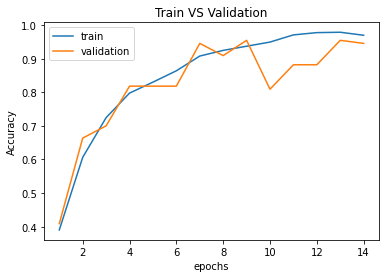

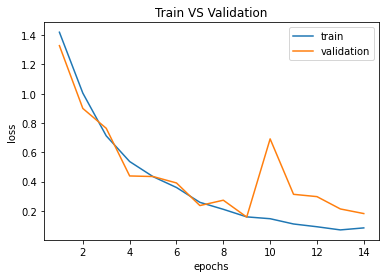

In [112]:
a111,l111,a112,l112 = plot_performance(tracker=history11,epochs=14)

In [114]:
# tr_acc,tr_loss,val_acc,val_loss
print("the train accuracy of the model : ",a111)
print(" the train loss of the model : ",l111)
print("="*50)
print(" the test accuracy of the model : ",a112)
print("the loss of the model :",l112)

the train accuracy of the model :  [0.39032620191574097, 0.6062992215156555, 0.7244094610214233, 0.7975252866744995, 0.8301462531089783, 0.8638920187950134, 0.9077615141868591, 0.9246343970298767, 0.9370078444480896, 0.9493813514709473, 0.9707536697387695, 0.9775028228759766, 0.9786276817321777, 0.9696288108825684]
 the train loss of the model :  [1.4202880859375, 1.0043431520462036, 0.7121105790138245, 0.5367364287376404, 0.43345901370048523, 0.359335720539093, 0.2578530013561249, 0.21028293669223785, 0.15856365859508514, 0.14598433673381805, 0.10996966063976288, 0.09106896072626114, 0.06944604218006134, 0.08325174450874329]
 the test accuracy of the model :  [0.40909090638160706, 0.6636363863945007, 0.699999988079071, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.9454545378684998, 0.9090909361839294, 0.9545454382896423, 0.8090909123420715, 0.8818181753158569, 0.8818181753158569, 0.9545454382896423, 0.9454545378684998]
the loss of the model : [1.3286395072937012, 0.899

In [117]:
# save the best model 
filepath1 = "/content/drive/MyDrive/kaggle/best_{}_model.h5".format("VGG-19")
best_vggmodel_19  = keras.models.load_model(filepath1)
# dump the classification model.
import pickle
pickle.dump(best_vggmodel_19, open('best_vgg19.pkl', 'wb'))

accuracy of the model :  0.9545454545454546


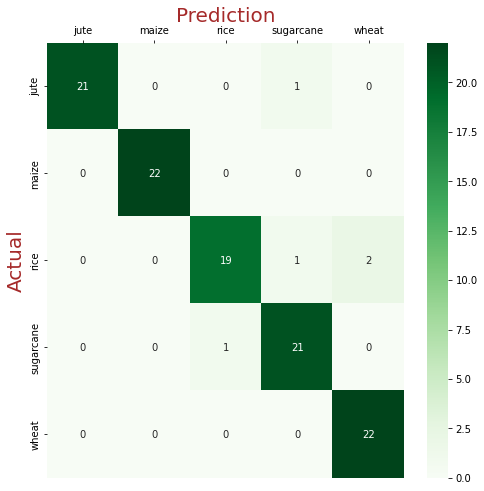

In [118]:
import pickle
from sklearn.metrics import confusion_matrix,accuracy_score
import tensorflow as tf
from keras.models import load_model

#load the best_model

best_model1 = pickle.load(open('best_vgg19.pkl', 'rb'))

#best_model1.fit(dx_train,y_train1) # fittting the model.
#best_model1 = load_model("/content/vgg19.h5")
y_predict = best_model1.predict(dx_test) # predicting the labels.

true_label = np.argmax(y_test1,axis=1) # use y_test
predict_label = np.argmax(y_predict,axis=1)

# plot the confusion matrix :

plt.figure(figsize=(8,8))
class_label = ["jute","maize","rice","sugarcane","wheat"]
fig = sns.heatmap(confusion_matrix(true_label,predict_label),annot=True,cmap="Greens",xticklabels=class_label,yticklabels=class_label)

fig.set_xlabel("Prediction",fontsize=20,color="brown")
fig.xaxis.set_label_position('top')
fig.xaxis.tick_top() # able to set top , bottom , for y axis able to set right/left.
fig.set_ylabel("Actual",fontsize=20,color="brown")

acc1 = accuracy_score(true_label,predict_label)
print("accuracy of the model : ",acc1)

In [119]:
df.head(3)

,path,crop,croplabel
0,/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg,sugarcane,3
1,/kaggle/input/kag2/sugarcane/sugarcane034a.jpeg,sugarcane,3
2,/kaggle/input/kag2/sugarcane/sugarcane032arot....,sugarcane,3


In [120]:
df["path"][0]

'/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg'

In [151]:
#ip = '/kaggle/input/agriculture-crop-images/kag2/rice/rice024ahs.jpeg'
ip = "/content/drive/MyDrive/Crop_Classifying/DJI_0131 resized.jpg"

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


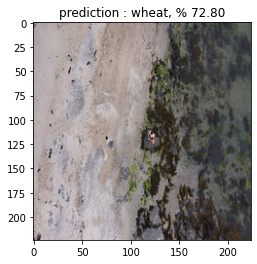

In [152]:
data_pipeline(ip,model=best_model1)